In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os

from matplotlib.dates import DateFormatter

In [2]:
def load_systems_data(degradation_setting, rain_scenario, file_type="concentrations", PMMoV=False):
    if file_type=="concentrations":
        if PMMoV:
            df_res = pd.read_csv(os.path.join("systems_output", "preprocessed", "PMMoV", f"{degradation_setting}_{rain_scenario}.csv"))
        else:
            df_res = pd.read_csv(os.path.join("systems_output", "preprocessed", f"{degradation_setting}_{rain_scenario}.csv"))
        df_res = df_res.loc[df_res.minutes>0,:]
    elif file_type=="flow_rates":
        df_res = pd.read_csv(os.path.join("systems_output", "preprocessed", f"flow_rates_{degradation_setting}_{rain_scenario}.csv"))
        df_res.minutes = df_res.minutes - 90 # ensure time consistency with concentrations
        df_res = df_res.loc[df_res.minutes>0,:]
        df_res.time = pd.to_datetime(df_res.time) - pd.Timedelta("90min")
    else:
        assert False, f"file_type {file_type} not supported"

    df_res.time = pd.to_datetime(df_res.time)

    # drop MW064, RW156 (invalid calculations of ++systems)
    df_res = df_res.loc[~df_res.sampling_point.isin(["MW064", "RW156"]), :]
    # rename sampling locations according to naming in the paper
    df_res.sampling_point = df_res.sampling_point.map({"MW022": "1", "MW023": "2", "MW017": "3", "MW043": "4", "MW048": "5", 
                        "RW157": "6", "MW046": "7", "MW061": "8", "RW143": "9", "RW141": "10",
                        "RW155": "11", "MW059": "12", "RW211": "13", "MW054": "14",
                        "RW126": "15", "MW052": "16"})
    return df_res

In [3]:
rain_scenario = "MittelstarkerRegen"
degradation_setting = "linear_degradation"

In [12]:
# Load Data
df_KeinRegen = load_systems_data(degradation_setting, "KeinRegen")
df_Rain = load_systems_data(degradation_setting, rain_scenario)

# We assume that PMMoV is stable for the small neighbourhood of the demonstrator study
df_PMMoV_KeinRegen = load_systems_data("no_degradation", "KeinRegen", PMMoV=True)
df_PMMoV_Rain = load_systems_data("no_degradation", rain_scenario, PMMoV=True)

### Normalisation with PMMoV

copies/l normalized = (copies/l of RNA) * (mean value of the normalization parameter on dry days) / (value of the normalization parameter)

source: https://pubs.acs.org/doi/10.1021/acsestwater.2c00306


#### Apply normalization of PMMoV values

In [13]:
# normalize w.r.t. PMMoV values
mean_values = df_PMMoV_KeinRegen.groupby(["sampling_point", "memilio_id"])["copies/l"].mean().reset_index().rename(columns={"copies/l": "mean_copies/l"})
df_PMMoV_Rain = pd.merge(df_PMMoV_Rain, mean_values, on=["sampling_point", "memilio_id"], how="left")

normalization_factors = df_PMMoV_Rain.loc[:,["time", "sampling_point", "memilio_id"]].copy()
normalization_factors["PMMoV_normalization_factor"] = df_PMMoV_Rain["mean_copies/l"]/df_PMMoV_Rain["copies/l"]

df_Rain = pd.merge(df_Rain.loc[:,["time", "sampling_point", "memilio_id", "copies/l"]], normalization_factors, on=["sampling_point", "memilio_id", "time"], how="inner")
df_Rain["PMMoV_normalized_copies/l"] = df_Rain["copies/l"]*df_Rain["PMMoV_normalization_factor"]
df_Rain.sort_values("time", inplace=True)

#### Store normalized data and calculate metrics

In [6]:
df_Rain.to_csv(os.path.join("systems_output", "normalized", f"PMMoV_normalized_{degradation_setting}_{rain_scenario}.csv"), index=False)

Metrics:

absolute error
$|{y_{no-rain}-y_{rain-normalized}}|$

relative error 
$\frac{|{y_{no-rain}-y_{rain-normalized}}|}{y_{no-rain}}$

averaged over all timepoints t

calculated individually per sampling location, simulation id

In [7]:
df_KeinRegen = df_KeinRegen[["time", "sampling_point", "memilio_id", "copies/l"]]
df_KeinRegen.columns = ["time", "sampling_point", "memilio_id", "KeinRegen_copies/l"]

print(df_Rain.size)
df_combined = df_Rain.merge(df_KeinRegen, on=["time", "sampling_point", "memilio_id"], how="outer")
print(df_combined.size)

32256000
188160000


In [8]:
# calculate metrics
df_combined["absolute_error_unnormalized"] = np.abs(df_combined["copies/l"] - df_combined["KeinRegen_copies/l"])
df_combined["absolute_error"] = np.abs(df_combined["PMMoV_normalized_copies/l"] - df_combined["KeinRegen_copies/l"])
df_combined["relative_error_unnormalized"] = df_combined["absolute_error_unnormalized"]/df_combined["KeinRegen_copies/l"]
df_combined["relative_error"] = df_combined["absolute_error"]/df_combined["KeinRegen_copies/l"]

In [9]:
df_metrics = df_combined.groupby(["sampling_point", "memilio_id"]).agg({"absolute_error": "mean", "relative_error": "mean",
                                                                        "absolute_error_unnormalized": "mean", "relative_error_unnormalized": "mean"})

df_metrics["NaNs_KeinRegen"] = df_KeinRegen.groupby(["sampling_point", "memilio_id"]).apply(lambda x: x["KeinRegen_copies/l"].isna().sum())
df_metrics["NaNs_Regen"] = df_Rain.groupby(["sampling_point", "memilio_id"]).apply(lambda x: x["copies/l"].isna().sum())

df_metrics.reset_index(inplace=True)
df_metrics.to_csv(os.path.join("systems_output", "normalized", "metrics", "PMMoV", "individual", f"{degradation_setting}_{rain_scenario}.csv"), index=False)

/tmp/ipykernel_125648/70062068.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_metrics["NaNs_KeinRegen"] = df_KeinRegen.groupby(["sampling_point", "memilio_id"]).apply(lambda x: x["KeinRegen_copies/l"].isna().sum())
/tmp/ipykernel_125648/70062068.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_metrics["NaNs_Regen"] = df_Rain.groupby(["sampling_point", "memilio_id"]).apply(lambda x: x["copies/l

In [10]:
metrics_per_sampling_point = df_metrics.groupby("sampling_point").mean().reset_index()[['sampling_point', 'absolute_error', 'relative_error',
       'absolute_error_unnormalized', 'relative_error_unnormalized', 'NaNs_KeinRegen', 'NaNs_Regen']]
metrics_per_sampling_point.to_csv(os.path.join("systems_output", "normalized", "metrics", "PMMoV", "per_sampling_location", f"{degradation_setting}_{rain_scenario}.csv"), index=False)

In [11]:
metrics_per_sampling_point

,sampling_point,absolute_error,relative_error,absolute_error_unnormalized,relative_error_unnormalized,NaNs_KeinRegen,NaNs_Regen
0,1,95.794211,inf,74.508616,inf,16.000,1.996
1,10,60.979667,inf,71.952555,inf,8.000,0.000
2,11,132.932047,inf,225.529426,inf,2633.588,277.732
3,12,88.097005,inf,107.063928,inf,0.000,0.000
4,13,13.676558,inf,19.208367,inf,5374.652,325.192
5,14,92.439887,inf,113.531050,inf,0.000,0.000
6,15,65.164921,inf,72.107061,inf,0.000,0.000
7,16,80.395335,inf,100.674015,inf,0.000,0.000
8,2,98.443968,inf,100.630030,inf,4538.332,427.036
9,3,95.162017,inf,95.309075,inf,14.000,1.000


#### Subselect specific sampling location

In [14]:
#subselect specific sampling point
sampling_point = "16"

df_KeinRegen = df_KeinRegen.loc[df_KeinRegen.sampling_point==sampling_point, :]
df_Rain = df_Rain.loc[df_Rain.sampling_point==sampling_point, :]
df_PMMoV_KeinRegen = df_PMMoV_KeinRegen.loc[df_PMMoV_KeinRegen.sampling_point==sampling_point, :]
df_PMMoV_Rain = df_PMMoV_Rain.loc[df_PMMoV_Rain.sampling_point==sampling_point, :]

#### Basic Visualization of PMMoV Data

<Axes: xlabel='minutes'>

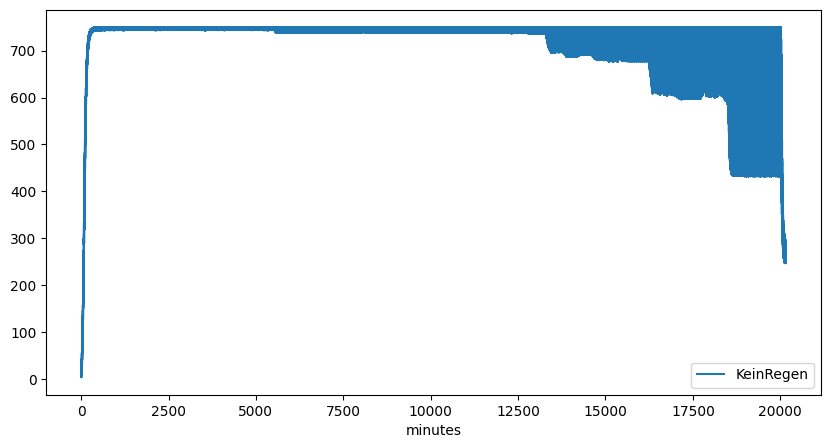

In [93]:
df_PMMoV_KeinRegen.sort_values("minutes", inplace=True)
df_PMMoV_KeinRegen.plot(x="minutes", y="copies/l", label="KeinRegen", figsize=(10, 5))

<Axes: xlabel='minutes'>

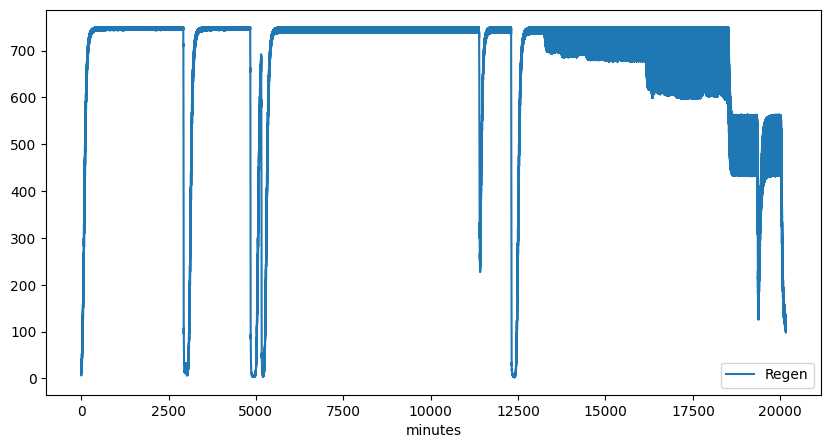

In [94]:
df_PMMoV_Rain.sort_values("minutes", inplace=True)
df_PMMoV_Rain.plot(x="minutes", y="copies/l", label="Regen", figsize=(10, 5))

#### Visualization of Normalization

/tmp/ipykernel_125648/1903569423.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
/tmp/ipykernel_125648/1903569423.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
/tmp/ipykernel_125648/1903569423.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


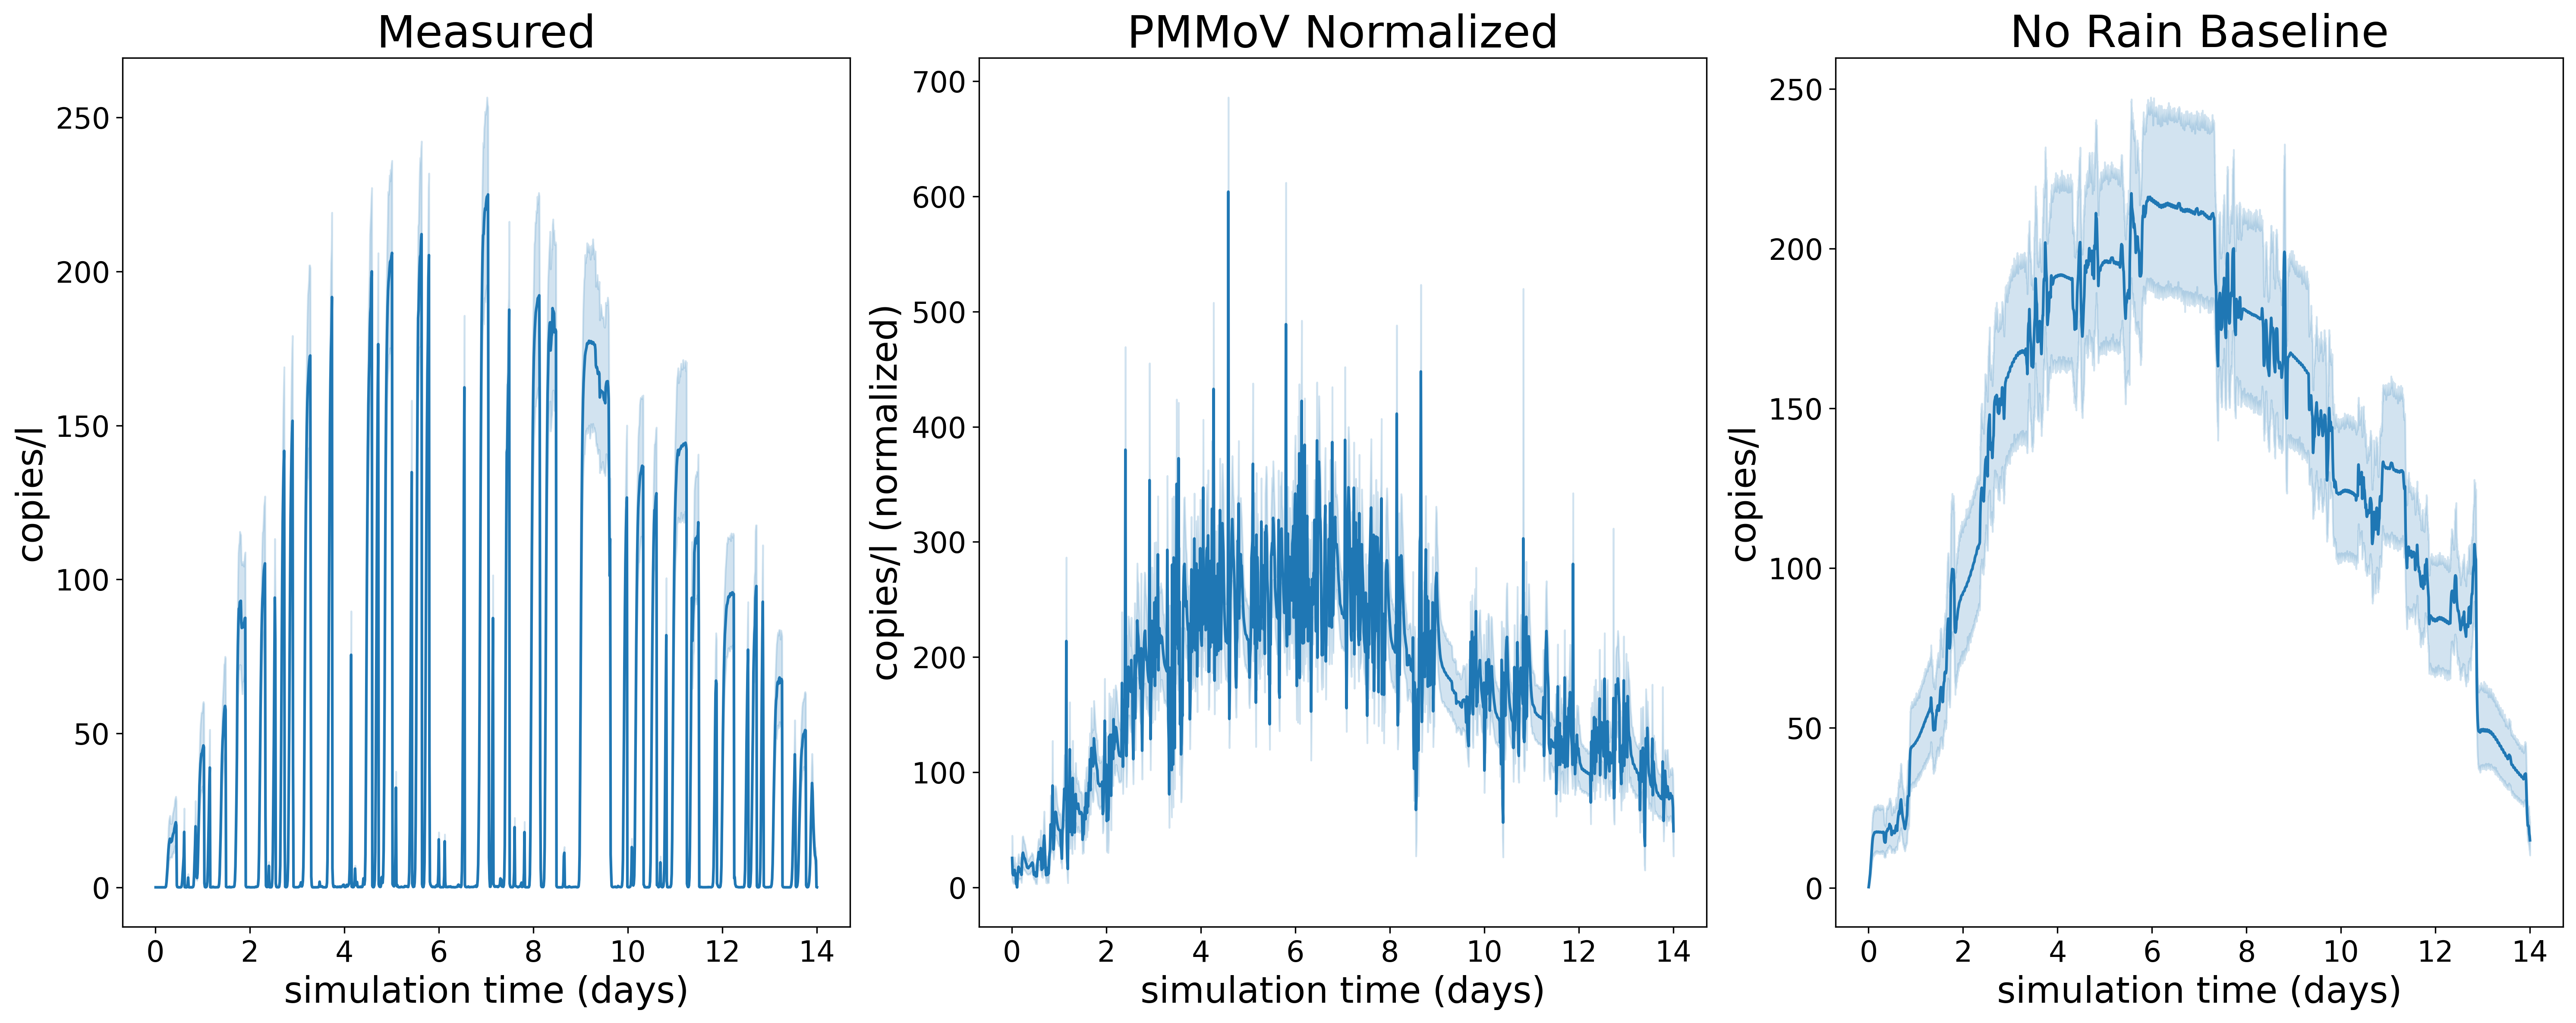

In [15]:
date_form = DateFormatter("%-d")

fig, axs = plt.subplots(ncols=3, sharey=False, figsize=(20, 8), dpi=300)

sns.lineplot(df_Rain, x="time", y="copies/l", ax=axs[0])
axs[0].set_title("Measured", fontsize=25)
axs[0].set_ylabel("copies/l", fontsize=20)
sns.lineplot(df_Rain, x="time", y="PMMoV_normalized_copies/l", ax=axs[1])
axs[1].set_ylabel("copies/l (normalized)", fontsize=20)
axs[1].set_title("PMMoV Normalized", fontsize=25)    
sns.lineplot(df_KeinRegen, x="time", y="copies/l", ax=axs[2])
axs[2].set_title("No Rain Baseline", fontsize=25)
axs[2].set_ylabel("copies/l", fontsize=20)

for i in range(3):
    axs[i].xaxis.set_major_formatter(date_form) 
    axs[i].set_xlabel(f"simulation time (days)", fontsize=20) # , fontsize=15
    axs[i].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
    axs[i].tick_params(axis='x', labelsize=16)
    axs[i].tick_params(axis='y', labelsize=16)

fig.tight_layout()
fig.savefig(os.path.join("systems_output", "plots", "normalization_strategy", "PMMoV", f"{rain_scenario}_{degradation_setting}_PMMoV_normalization_station_{sampling_point}.png"))

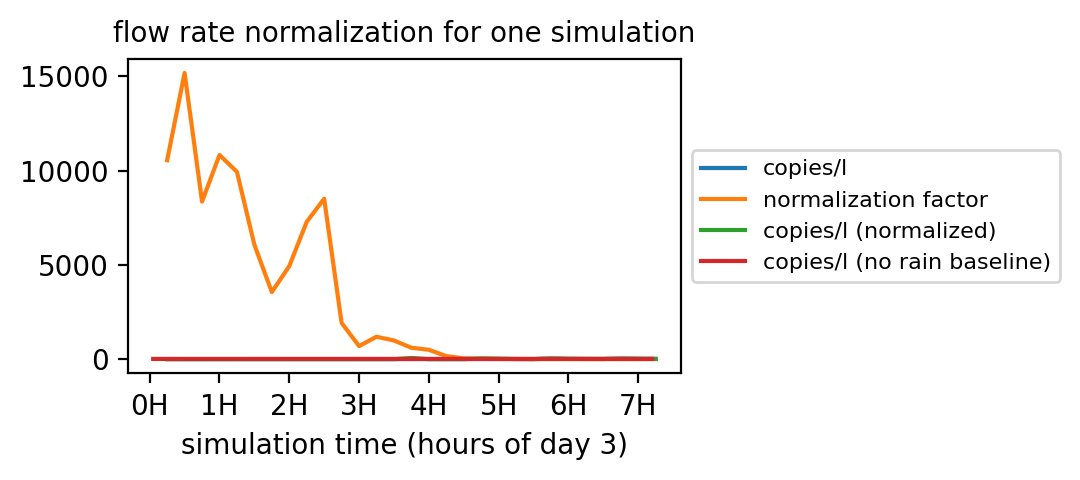

In [18]:
simulation_id = 3

df_Rain['minutes'] = (df_Rain['time'] - df_Rain['time'].min()).dt.total_seconds() // 60
df_KeinRegen['minutes'] = (df_KeinRegen['time'] - df_KeinRegen['time'].min()).dt.total_seconds() // 60

df_sub = df_Rain.loc[df_Rain.memilio_id==simulation_id, :]
df_sub_sub = df_sub.loc[(df_sub.minutes>= 2*24*60) & (df_sub.minutes<= 2.3*24*60), :]

fig, axs = plt.subplots(figsize=(5.5,2.5), dpi=200)
plt.plot(df_sub_sub["time"], df_sub_sub["copies/l"], label="copies/l")
plt.plot(df_sub_sub["time"], df_sub_sub["PMMoV_normalization_factor"], label="normalization factor")
plt.plot(df_sub_sub["time"], df_sub_sub["PMMoV_normalized_copies/l"], label="copies/l (normalized)")

df_sub = df_KeinRegen.loc[df_KeinRegen.memilio_id==simulation_id, :]
df_sub_sub = df_sub.loc[(df_sub.minutes>= 2*24*60) & (df_sub.minutes<= 2.3*24*60), :]
plt.plot(df_sub_sub["time"], df_sub_sub["copies/l"], label="copies/l (no rain baseline)")
date_form_2 = DateFormatter("%-HH")
axs.xaxis.set_major_formatter(date_form_2) 
axs.set_xlabel(f"simulation time (hours of day 3)", fontsize=10) # , fontsize=15
# axs.set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
plt.title("flow rate normalization for one simulation", fontsize=10)
plt.tight_layout()
fig.savefig(os.path.join("systems_output", "plots", "normalization_strategy", "PMMoV", f"{rain_scenario}_{degradation_setting}_PMMoV_normalization_station_{sampling_point}_simulationID_{simulation_id}.png"))